# 06. 토픽 모델링(Topic Modeling) - 20 뉴스그룹

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 모토사이클, 야구, 그래픽스, 윈도우즈, 중동, 기독교, 전자공학, 의학 8개 주제를 추출
cats = ['rec.motorcycles', 'rec.sport.baseball', 'comp.graphics', 'comp.windows.x',
        'talk.politics.mideast', 'soc.religion.christian', 'sci.electronics', 'sci.med']

# 위에서 cats 변수로 기재된 카테고리만 추출. featch_20newsgroups()의 categories에 cats 입력
news_df = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'),
                             categories=cats, random_state=0)

# LDA는 Count기반의 벡터화만 적용합니다.
count_vect = CountVectorizer(max_df=0.95, max_features=1000, min_df=2, stop_words='english',
                             ngram_range=(1, 2))
feat_vect = count_vect.fit_transform(news_df.data)
print('CountVectorizer Shape:', feat_vect.shape)

CountVectorizer Shape: (7862, 1000)


In [2]:
lda = LatentDirichletAllocation(n_components=8, random_state=0)
lda.fit(feat_vect)
print(lda.components_.shape)
lda.components_

(8, 1000)


array([[3.60992018e+01, 1.35626798e+02, 2.15751867e+01, ...,
        3.02911688e+01, 8.66830093e+01, 6.79285199e+01],
       [1.25199920e-01, 1.44401815e+01, 1.25045596e-01, ...,
        1.81506995e+02, 1.25097844e-01, 9.39593286e+01],
       [3.34762663e+02, 1.25176265e-01, 1.46743299e+02, ...,
        1.25105772e-01, 3.63689741e+01, 1.25025218e-01],
       ...,
       [3.60204965e+01, 2.08640688e+01, 4.29606813e+00, ...,
        1.45056650e+01, 8.33854413e+00, 1.55690009e+01],
       [1.25128711e-01, 1.25247756e-01, 1.25005143e-01, ...,
        9.17278769e+01, 1.25177668e-01, 3.74575887e+01],
       [5.49258690e+01, 4.47009532e+00, 9.88524814e+00, ...,
        4.87048440e+01, 1.25034678e-01, 1.25074632e-01]])

In [3]:
def display_topics(model, feature_names, no_top_words):
  for topic_index, topic in enumerate(model.components_):
    print('Topic #', topic_index)

    # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array 인덱스를 반환
    topic_word_indexes= topic.argsort()[::-1]
    top_indexes = topic_word_indexes[:no_top_words]

    # top_indexes대상인 인덱스별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
    feature_concat = ' '.join([feature_names[i] for i in top_indexes])
    print(feature_concat)

# CountVectorizer객체 내의 전체 word의 명칭을 get_features_names()를 통해 추출
feature_names = count_vect.get_feature_names_out()

# 토픽별 가장 연관도가 높은 word를 15개만 추출
display_topics(lda, feature_names, 15)

Topic # 0
year 10 game medical health team 12 20 disease cancer 1993 games years patients good
Topic # 1
don just like know people said think time ve didn right going say ll way
Topic # 2
image file jpeg program gif images output format files color entry 00 use bit 03
Topic # 3
like know don think use does just good time book read information people used post
Topic # 4
armenian israel armenians jews turkish people israeli jewish government war dos dos turkey arab armenia 000
Topic # 5
edu com available graphics ftp data pub motif mail widget software mit information version sun
Topic # 6
god people jesus church believe christ does christian say think christians bible faith sin life
Topic # 7
use dos thanks windows using window does display help like problem server need know run


# 07. 문서 군집화 소개와 실습(Opinion Review 데이터 세트)

## Opinion Review 데이터 세트를 이용한 문서 군집화 수행하기

In [5]:
from google.colab import drive
import os
import glob
import pandas as pd

# 데이터 파일 경로 설정
path = '/content/drive/MyDrive/Euron 7기(2024)/topics'

# 모든 .data 파일 찾기
all_files = glob.glob(os.path.join(path, "*.data"))

# 파일명과 내용 저장
filename_list = []
opinion_text = []

for file_ in all_files:
      filename_ = os.path.basename(file_)
      filename = filename_.rsplit('.txt.data', 1)[0]

      with open(file_, 'r', encoding='latin1') as f:
          content = f.read()

      filename_list.append(filename)
      opinion_text.append(content)


# DataFrame 생성
document_df = pd.DataFrame({'filename': filename_list, 'opinion_text': opinion_text})
document_df.head()



,filename,opinion_text
0,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n but for the m..."
1,battery-life_ipod_nano_8gb,short battery life I moved up from an 8gb .\...
2,buttons_amazon_kindle,I thought it would be fitting to christen my K...
3,comfort_honda_accord_2008,"Drivers seat not comfortable, the car itself ..."
4,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 23Wh ..."


In [8]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

# 입력으로 들어온 token단어들에 대해서 lemmatization 어근 변환
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# TfidfVectorizer 객체 생성 시 tokenizer인자로 해당 함수를 설정하여 lemmatization 적용
# 입력으로 문장을 받아서 stop words 제거-> 소문자 변환 -> 단어 토큰화 -> lemmatization 어근 변환
def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',
                             ngram_range=(1, 2), min_df=0.05, max_df=0.85)
# opinion_text 칼럼 값으로 피처 벡터화 수행
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [10]:
from sklearn.cluster import KMeans

# 5개 집합으로 군집화 수행
km_cluster = KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

In [11]:
document_df['cluster_label'] = cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n but for the m...",1
1,battery-life_ipod_nano_8gb,short battery life I moved up from an 8gb .\...,3
2,buttons_amazon_kindle,I thought it would be fitting to christen my K...,1
3,comfort_honda_accord_2008,"Drivers seat not comfortable, the car itself ...",4
4,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 23Wh ...",3


In [12]:
document_df[document_df['cluster_label']==0].sort_values(by='filename')

,filename,opinion_text,cluster_label
16,food_holiday_inn_london,The room was packed to capacity with queues a...,0
17,location_bestwestern_hotel_sfo,"Good Value good location , ideal choice .\nGr...",0
27,location_holiday_inn_london,Great location for tube and we crammed in a f...,0
22,price_holiday_inn_london,"All in all, a normal chain hotel on a nice loc...",0


In [13]:
document_df[document_df['cluster_label']==1].sort_values(by='filename')

,filename,opinion_text,cluster_label
0,accuracy_garmin_nuvi_255W_gps,", and is very, very accurate .\n but for the m...",1
2,buttons_amazon_kindle,I thought it would be fitting to christen my K...,1
19,directions_garmin_nuvi_255W_gps,You also get upscale features like spoken dir...,1
14,display_garmin_nuvi_255W_gps,3 quot widescreen display was a bonus .\n Thi...,1
18,eyesight-issues_amazon_kindle,It feels as easy to read as the K1 but doesn'...,1
11,features_windows7,"I had to uninstall anti, virus and selected o...",1
15,fonts_amazon_kindle,Being able to change the font sizes is awesome...,1
8,keyboard_netbook_1005ha,", I think the new keyboard rivals the great h...",1
31,navigation_amazon_kindle,"In fact, the entire navigation structure has ...",1
28,price_amazon_kindle,"If a case was included, as with the Kindle 1,...",1


In [14]:
document_df[document_df['cluster_label']==2].sort_values(by='filename')

,filename,opinion_text,cluster_label
6,bathroom_bestwestern_hotel_sfo,"The room was not overly big, but clean and ve...",2
20,food_swissotel_chicago,The food for our event was delicious .\n The ...,2
13,free_bestwestern_hotel_sfo,The wine reception is a great idea as it is ni...,2
29,parking_bestwestern_hotel_sfo,Parking was expensive but I think this is com...,2
26,room_holiday_inn_london,"We arrived at 23,30 hours and they could not r...",2
33,rooms_bestwestern_hotel_sfo,"Great Location , Nice Rooms , Helpless Con...",2
30,rooms_swissotel_chicago,The Swissotel is one of our favorite hotels in...,2
41,service_bestwestern_hotel_sfo,Both of us having worked in tourism for over ...,2
43,service_holiday_inn_london,"not customer, oriented hotelvery low service l...",2
44,service_swissotel_hotel_chicago,Mediocre room and service for a very extravag...,2


In [15]:
document_df[document_df['cluster_label']==3].sort_values(by='filename')

,filename,opinion_text,cluster_label
5,battery-life_amazon_kindle,After I plugged it in to my USB hub on my com...,3
1,battery-life_ipod_nano_8gb,short battery life I moved up from an 8gb .\...,3
4,battery-life_netbook_1005ha,"6GHz 533FSB cpu, glossy display, 3, Cell 23Wh ...",3
32,performance_netbook_1005ha,The Eee Super Hybrid Engine utility lets user...,3
39,screen_ipod_nano_8gb,"As always, the video screen is sharp and brig...",3
42,sound_ipod_nano_8gb,headphone jack i got a clear case for it and ...,3
49,video_ipod_nano_8gb,"I bought the 8, gig Ipod Nano that has the bui...",3
46,voice_garmin_nuvi_255W_gps,The voice prompts and maps are wonderful esp...,3


In [16]:
document_df[document_df['cluster_label']==4].sort_values(by='filename')

,filename,opinion_text,cluster_label
3,comfort_honda_accord_2008,"Drivers seat not comfortable, the car itself ...",4
7,comfort_toyota_camry_2007,Ride seems comfortable and gas mileage fairly...,4
9,gas_mileage_toyota_camry_2007,Ride seems comfortable and gas mileage fairly...,4
10,interior_honda_accord_2008,I love the new body style and the interior is...,4
12,interior_toyota_camry_2007,"First of all, the interior has way too many c...",4
25,mileage_honda_accord_2008,"It's quiet, get good gas mileage and looks cl...",4
24,performance_honda_accord_2008,"Very happy with my 08 Accord, performance is q...",4
21,quality_toyota_camry_2007,I previously owned a Toyota 4Runner which had...,4
34,seats_honda_accord_2008,Front seats are very uncomfortable .\n No mem...,4
50,transmission_toyota_camry_2007,"After slowing down, transmission has to be k...",4


In [17]:
from sklearn.cluster import KMeans

# 3개의 집합으로 군집화
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

# 소속 군집을 cluster_label 칼럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label'] = cluster_label
document_df.sort_values(by='cluster_label')

,filename,opinion_text,cluster_label
20,food_swissotel_chicago,The food for our event was delicious .\n The ...,0
22,price_holiday_inn_london,"All in all, a normal chain hotel on a nice loc...",0
17,location_bestwestern_hotel_sfo,"Good Value good location , ideal choice .\nGr...",0
16,food_holiday_inn_london,The room was packed to capacity with queues a...,0
27,location_holiday_inn_london,Great location for tube and we crammed in a f...,0
23,satellite_garmin_nuvi_255W_gps,It's fast to acquire satellites .\n If you've...,1
49,video_ipod_nano_8gb,"I bought the 8, gig Ipod Nano that has the bui...",1
28,price_amazon_kindle,"If a case was included, as with the Kindle 1,...",1
31,navigation_amazon_kindle,"In fact, the entire navigation structure has ...",1
21,quality_toyota_camry_2007,I previously owned a Toyota 4Runner which had...,1


## 군집별 핵심 단어 추출하기

In [18]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape:', cluster_centers.shape)
print(cluster_centers)

cluster_centers shape: (3, 4412)
[[0.         0.         0.00552305 ... 0.         0.00217772 0.00217772]
 [0.00933972 0.00925341 0.00116699 ... 0.0065334  0.         0.        ]
 [0.         0.         0.00249971 ... 0.         0.00096562 0.00064206]]


In [19]:
# 군집별 top n 핵심 단어, 그 단어의 중심 위치 상댓값, 대상 파일명을 반환
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num,
                        top_n_features=10):
  cluster_details = {}

  # cluster_centers array의 값이 큰 순으로 정렬된 인덱스 값을 반환
  # 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함
  centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:,::-1]

  # 개별 군집별로 반복하면서 핵심 단어, 그 단어의 중심 위치 상댓값, 대상 파일명 입력
  for cluster_num in range(clusters_num):
    # 개별 군집별 정보를 담을 데이터 초기화
    cluster_details[cluster_num] = {}
    cluster_details[cluster_num]['cluster'] = cluster_num

    # cluster_centers_.argsort()[:, ::-1]로 구한 인덱스를 이용해 top n 피처 단어를 구함
    top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
    top_features = [feature_names[ind] for ind in top_feature_indexes]

    # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함
    top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()

    # cluster_details 딕셔너리 객체에 개별 군집별 핵심단어와 중심위치 상댓값, 해당 파일명 입력
    cluster_details[cluster_num]['top_features'] = top_features
    cluster_details[cluster_num]['top_features_value'] = top_feature_values
    filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
    filenames = filenames.values.tolist()

    cluster_details[cluster_num]['filenames'] = filenames

  return cluster_details

In [20]:
def print_cluster_details(cluster_details):
  for cluster_num, cluster_detail in cluster_details.items():
    print('####### Cluster {0}'.format(cluster_num))
    print('Top features:', cluster_detail['top_features'])
    print('Reviews 파일명:', cluster_detail['filenames'][:7])
    print('=============================================')

In [21]:
feature_names = tfidf_vect.get_feature_names_out()

cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data=document_df,
                                      feature_names=feature_names, clusters_num=3, top_n_features=10)
print_cluster_details(cluster_details)

####### Cluster 0
Top features: ['food', 'location', 'hotel', 'price', 'room', 'great location', 'tube', 'restaurant', 'breakfast', 'london']
Reviews 파일명: ['food_holiday_inn_london', 'location_bestwestern_hotel_sfo', 'food_swissotel_chicago', 'price_holiday_inn_london', 'location_holiday_inn_london']
####### Cluster 1
Top features: ['screen', 'battery', 'keyboard', 'battery life', 'life', 'kindle', 'direction', 'video', 'voice', 'size']
Reviews 파일명: ['accuracy_garmin_nuvi_255W_gps', 'battery-life_ipod_nano_8gb', 'buttons_amazon_kindle', 'battery-life_netbook_1005ha', 'battery-life_amazon_kindle', 'keyboard_netbook_1005ha', 'features_windows7']
####### Cluster 2
Top features: ['room', 'service', 'staff', 'interior', 'hotel', 'seat', 'mileage', 'comfortable', 'gas', 'gas mileage']
Reviews 파일명: ['comfort_honda_accord_2008', 'bathroom_bestwestern_hotel_sfo', 'comfort_toyota_camry_2007', 'gas_mileage_toyota_camry_2007', 'interior_honda_accord_2008', 'interior_toyota_camry_2007', 'free_bestw

# 08. 문서 유사도

## 두 벡터 사잇각

In [ ]:
import numpy as np

def cos_similarity(v1, v2):
  dot_product = np.dot(v1, v2)
  l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
  similarity = dot_product / l2_norm

  return similarity

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends',
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


In [ ]:
# TFidfVectorizer로 transform()한 결과는 희소 행렬이므로 밀집 행렬로 변환
feature_vect_dense = feature_vect_simple.todense()

# 첫 번째 문장과 두 번째 문장의 피터 벡터 추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect2 = np.array(feature_vect_dense[1]).reshape(-1, )

# 첫 번째 문장과 두 번째 문장의 피처 벡터로 두 개 문장의 코사인 유사도 추출
similarity_simple = cos_similarity(vect1, vect2)
print('문장 1, 문장 2 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 2 Cosine 유사도: 0.402


In [ ]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )
similarity_simple = cos_similarity(vect1, vect3)
print('문장 1, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

vect2 = np.array(feature_vect_dense[1]).reshape(-1, )
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )
similarity_simple = cos_similarity(vect2, vect3)
print('문장 2, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 3 Cosine 유사도: 0.404
문장 2, 문장 3 Cosine 유사도: 0.456


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0], feature_vect_simple[1:])
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


In [ ]:
similarity_simple_pair = cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)
print('shape:', similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


## Opinion Review 데이터 세트를 이용한 문서 유사도 측정

In [22]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

# 단어 원형 추출 함수
lemmar = WordNetLemmatizer()
def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

# 특수 문자 사전 생성: {33: None ...}
# ord(): 아스키 코드 생성
remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)

# 특수 문자 제거 및 단어 원형 추출
def LemNormalize(text):
    # 텍스트 소문자 변경 후 특수 문자 제거
    text_new = text.lower().translate(remove_punct_dict)

    # 단어 토큰화
    word_tokens = nltk.word_tokenize(text_new)

    # 단어 원형 추출
    return LemTokens(word_tokens)

In [38]:
from google.colab import drive
import os
import glob
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# 데이터 파일 경로 설정
path = '/content/drive/MyDrive/Euron 7기(2024)/topics'

# 모든 .data 파일 찾기
all_files = glob.glob(os.path.join(path, "*.data"))

# 파일명과 내용 저장
filename_list = []
opinion_text = []

for file_ in all_files:
      filename_ = os.path.basename(file_)
      filename = filename_.rsplit('.txt.data', 1)[0]

      with open(file_, 'r', encoding='latin1') as f:
          content = f.read()

      filename_list.append(filename)
      opinion_text.append(content)


# DataFrame 생성
document_df = pd.DataFrame({'filename': filename_list, 'opinion_text': opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',
                             ngram_range=(1,2), min_df=0.05, max_df=0.85)
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [40]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=1인 데이터는 호텔로 군집화된 데이터임. DataFrame에서 해당 인덱스를 추출
hotel_indexes = document_df[document_df['cluster_label']==2].index
print('호텔로 군집화 된 문서들의 DataFrame Index:', hotel_indexes)

# 호텔로 군집화된 데이터 중 첫 번째 문서를 추출해 파일명 표시
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명 ', comparison_docname, ' 와 타 문서 유사도 #####')

'''document_df에서 추출한 Index 객체를 feature_vect로 입려갷 호텔 군집화된 feature_vect 추출
이를 이용해 호텔로 군집화된 문서 중 첫 번째 문서와 다른 문서 간의 코사인 유사도 측정'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 군집화 된 문서들의 DataFrame Index: Index([3, 6, 7, 9, 10, 12, 13, 24, 25, 26, 29, 30, 33, 34, 36, 41, 43, 44, 47], dtype='int64')
##### 비교 기준 문서명  comfort_honda_accord_2008  와 타 문서 유사도 #####
[[1.         0.03719076 0.83740227 0.15551075 0.33083123 0.25930365
  0.01008547 0.27457921 0.16354381 0.05453009 0.03339692 0.06596273
  0.06576679 0.65594785 0.02766472 0.04065194 0.03450093 0.04081364
  0.02076245]]


Text(0.5, 1.0, 'comfort_honda_accord_2008')

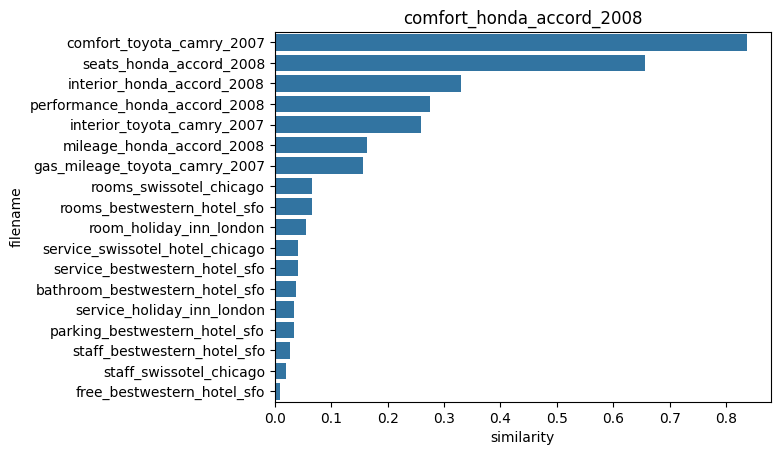

In [41]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# 첫 번째 문서와 타 문서 간 유사도가 큰 순으로 정렬한 인덱스를 추출하되 자기 자신은 제외
sorted_index = similarity_pair.argsort()[:, ::-1]
sorted_index = sorted_index[:, 1:]

# 유사도가 큰 순으로 hotel_indexes를 추출해 재정렬
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 인덱스와 유사도 값을 이용해 파일명과 유사도 값을 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x='similarity', y='filename', data=hotel_1_sim_df)
plt.title(comparison_docname)

# 09. 한글 텍스트 처리 - 네이버 영화 평점 감성 분석

## KoNLPy 소개

In [43]:
pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.8/493.8 kB 25.9 MB/s eta 0:00:00


In [48]:
import pandas as pd

train_df = pd.read_csv('/content/ratings_train.txt', sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [49]:
train_df['label'].value_counts()

,count
label,
0,75173
1,74827


In [50]:
import re

train_df = train_df.fillna(' ')
# 정규 표현식을 이용해 숫자를 공백으로 변경(정규 표현식으로 \d는 숫자를 의미함)
train_df['document'] = train_df['document'].apply(lambda x : re.sub(r"\d+", "", x))

# 테스트 데이터 세트를 로딩하고 동일하게 Null 및 숫자를 공백으로 변환
test_df = pd.read_csv('/content/ratings_test.txt', sep='\t')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply(lambda x : re.sub(r"\d+", "", x))

# id 칼럼 삭제 수행
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

In [51]:
from konlpy.tag import Twitter

twitter = Twitter()
def tw_tokenizer(text):
  # 입력 인자로 들어온 텍스트를 형태소 단어로 토큰화해 리스트 형태로 반환
  tokens_ko = twitter.morphs(text)
  return tokens_ko

/usr/local/lib/python3.10/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Twitter 객체의 morphs() 객체를 이용한 tokenizer를 사용. ngram_range는 (1, 2)
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1, 2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

In [54]:
# 로지스틱 회귀를 이용해 감성 분석 분류 수행
lg_clf = LogisticRegression(random_state=0)

# 파라미터 C 최적화를 위해 GridSearchCV를 이용
params = { 'C': [1,3.5, 4.5, 5.5, 10] }

grid_cv = GridSearchCV(lg_clf, param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv.fit(tfidf_matrix_train, train_df['label'])
print(grid_cv.best_params_, round(grid_cv.best_score_, 4))

Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'C': 3.5} 0.8593


In [55]:
from sklearn.metrics import accuracy_score

# 학습 데이터를 적용한 TfidfVectorizer를 이용해 테스트 데이터를 TF-IDF 값으로 피처 변환함
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

# classifier는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
best_estimator = grid_cv.best_estimator_
preds = best_estimator.predict(tfidf_matrix_test)

print('Logistic Regression 정확도: ', accuracy_score(test_df['label'], preds))

Logistic Regression 정확도:  0.8615
